# ATML Project Report

### Group 2
Members: Léonard Barras & Nathan Gyger

Github: https://github.com/svapili/FS2019_ATML_Group2 

# Melanoma image classification
### Goal:
Implement a deep learning algorithm to classify mole pictures as benign or malignant using the [ISIC database](https://isic-archive.com/).

### Approach description:
TODO: write a description
- Class imbalance => data augmentation
- Images => CNN as a logical choice
- Transfer learning

# Results
TODO: add accuracy table for different parameters

## Learning curve
TODO: add graphic

# Example of use

In [1]:
import torch
print("Hello from cluster!")
print("Available GPU: ", torch.cuda.get_device_name(0))    

Hello from cluster!
Available GPU:  Tesla K20c


### Imports and configuration

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import util
import csv
import glob

In [3]:
# Custom functions
import dataSplitter
import loader
import dataAugmenter
import SimpleNet
import train
import test_

In [4]:
# Paths definitions
Path = '/var/tmp/'
dataDir = Path + 'ISIC-images'
trainDir = Path + 'ISIC-images/train/'
testDir = Path + 'ISIC-images/test/'
valDir = Path + 'ISIC-images/val/'

In [5]:
# Data pre-processing
newDataSplit = False # Set to true to split the data randomly again. Data have first to be downloaded and extracted with data_extractor.py
dataPreprocessing = False # Set to true to resize and augment the data

In [6]:
# Check if we can use CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Learning rate config
learning_rate = 0.001
n_epochs = 10
first_training_status = True

### Data pre-processing

In [8]:
# Performs a new random split of the data
# Data have first to be downloaded and extracted with data_extractor.py
if (newDataSplit):
    testRatio = .1
    valRatio = .1
    split(trainDir, testDir, valDir, testRatio, valRatio)

In [9]:
# Preprocessing the data (resizing and augmenting)
if (dataPreprocessing):
    preprocessData([trainDir, testDir, valDir])

### Data loading

Size of the dataset objects:  {'train': 23085, 'test': 2829, 'val': 2587}
Images class names:  ['benign', 'malignant']
Sample images:


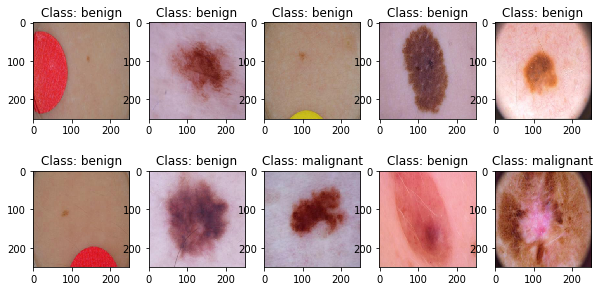

In [12]:
# Create dataset and dataloaders objects
image_datasets, dataloaders = loader.melanomaDataLoader(dataDir)

# Get dataset objects sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
print("Size of the dataset objects: ", dataset_sizes)

# Get the class names
class_names = image_datasets['train'].classes
print("Images class names: ", class_names)

# Visualize sample images
print("Sample images:")
loader.showSample(dataloaders, dataset_sizes, class_names)

### Network configuration

In [13]:
model = models.AlexNet(num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

model = model.to(device)

train_losses, train_accuracies = ['train_losses'], ['train_accuracies']
val_losses, val_accuracies = ['val_losses'], ['val_accuracies']

### Training and validation

In [14]:
# test train and test function
if first_training_status is True:
    train_loss, train_accuracy = train.train(model, dataloaders['train'], optimizer, loss_fn, device, status = True)
    val_loss, val_accuracy = test_.test(model, dataloaders['val'], loss_fn, device)
    test_loss, test_accuracy = test_.test(model, dataloaders['test'], loss_fn, device)
    print('Test training: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, test_loss: {:.4f}, test_accuracy: {:.4f}'.format(
        train_loss,
        train_accuracy,
        val_loss,
        val_accuracy,
        test_loss,
        test_accuracy))

lenght of dataset : 23085
Training iteration 0: loss 0.7012, accuracy 18.7500
# 0 output: 0, # 1 output: 32
Training iteration 1: loss 0.6985, accuracy 25.0000
# 0 output: 0, # 1 output: 64
Training iteration 2: loss 0.6958, accuracy 29.1667
# 0 output: 0, # 1 output: 96
Training iteration 3: loss 0.6982, accuracy 28.9062
# 0 output: 0, # 1 output: 128
Training iteration 4: loss 0.6975, accuracy 29.3750
# 0 output: 0, # 1 output: 160
Training iteration 5: loss 0.7008, accuracy 27.0833
# 0 output: 0, # 1 output: 192
Training iteration 6: loss 0.6994, accuracy 25.8929
# 0 output: 0, # 1 output: 224
Training iteration 7: loss 0.6940, accuracy 28.5156
# 0 output: 0, # 1 output: 256
Training iteration 8: loss 0.6963, accuracy 29.8611
# 0 output: 0, # 1 output: 288
Training iteration 9: loss 0.6983, accuracy 29.3750
# 0 output: 0, # 1 output: 320
Training iteration 10: loss 0.6977, accuracy 28.9773
# 0 output: 0, # 1 output: 352
Training iteration 11: loss 0.6950, accuracy 29.6875
# 0 output

### Testing

### Saving data